# 03.2 Brownian Motion

<h3><span style="color:#800000;"><strong>Authored by:</strong> <em>Alexandre Mathias DONNAT, Sr</em></span></h3>

**Goal of this notebook**
- Remind the role of Brownian motion inside the landscape of stochastic processes (Lévy processes, diffusions).
- Introduce the formal definition of a standard Brownian motion.
- Simulate Brownian paths and study their marginal distributions.
- Empirically check key properties: Gaussian marginals $W_t \sim \mathcal{N}(0,t)$, independent and stationary increments, quadratic variation $[W]_T = T$.
- Prepare the ground for continuous-time martingales, Itô calculus and SDEs in the following notebooks.

**This notebook**

Focuses on Brownian motion as the central continuous-time noise driving diffusion models in finance.


# 0. Brownian motion at the intersection of Lévy processes and diffusions

We work on a filtered probability space

$$(\Omega, \mathcal{F}, (\mathcal{F}_t)_{t \geq 0}, \mathbb{P}).$$

A stochastic process $(X_t)_{t \geq 0}$ is simply a family of random variables indexed by time, describing how a random quantity evolves.
A process is called Markov when the future, conditionally on the past, depends only on the present state—no memory beyond the current point.

In continuous time, two broad classes of models dominate quantitative finance.
The first one consists of Lévy processes, which start at zero, have stationary and independent increments, and evolve along càdlàg paths (right-continuous with left limits). These processes may exhibit jumps. The Poisson process is the canonical example, and many jump-diffusion models are built from compound Poisson or more general Lévy processes.

The second class contains diffusion processes, which have continuous trajectories and arise as solutions of stochastic differential equations

$$dX_t = b(t, X_t) \, dt + \sigma(t, X_t) \, dW_t.$$

This includes classical models such as the Ornstein–Uhlenbeck process, geometric Brownian motion, and stochastic-volatility diffusions like Heston.

Brownian motion (or Wiener process) sits at the crossroads of these two worlds. On one hand, it is a Lévy process: it starts at zero, has stationary and independent increments, and satisfies the formal definition of a Lévy process with the special feature of having no jumps. On the other hand, Brownian motion is also the fundamental driving noise of diffusion SDEs, providing the random fluctuations that shape continuous-path models.

If one visualizes a Venn diagram, Lévy processes would form the left region (with Poisson processes and general jump models), diffusion processes would form the right region (OU, GBM, Heston, etc.), and the intersection of these two regions is precisely Brownian motion, the unique Lévy process that also has continuous trajectories and thus serves as the building block for diffusion models.

# Definition of standard Brownian motion

A process $(W_t)_{t \geq 0}$ is a standard Brownian motion with respect to $(F_t)$ if:

1. $W_0 = 0$ almost surely,

2. $W$ has almost surely continuous paths,

3. it has independent increments:
    $W_{t_k} - W_{t_{k-1}}, \ldots, W_{t_1} - W_{t_0}$ are independent for $0 \leq t_0 < \cdots < t_k$,

4. it has Gaussian, centered, stationary increments:
    $W_t - W_s \sim \mathcal{N}(0, t-s), \quad 0 \leq s < t$.

From this definition, we immediately obtain:

- $W_t \sim \mathcal{N}(0, t)$,
- $\mathbb{E}[W_t] = 0$,
- $\text{Var}(W_t) = t$,
- $\text{Cov}(W_s, W_t) = \min(s, t)$.

In the rest of the notebook, we work with simulated Brownian paths and check these properties numerically.


### What Brownian motion is used for ?

Brownian motion plays a central role in continuous-time stochastic modelling.
It provides the elementary source of randomness driving diffusion SDEs, and its properties (Gaussian increments, independence, continuity) make it the canonical model for random fluctuations.

In finance, it is the noise behind geometric Brownian motion, stochastic volatility models, and risk-neutral pricing. In physics, it models particle motion subject to microscopic shocks. In mathematics, it is the fundamental continuous-time martingale and appears in the construction of Itô calculus.

# 2. Simulating Brownian paths

We first visualise a few simulated paths to build intuition.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

rng = np.random.default_rng(12)

plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["axes.grid"] = True

def simulate_brownian_paths(T=1.0, n_steps=1000, n_paths=1, rng=None):
    """
    Simulate n_paths standard Brownian motions on [0,T] using exact Gaussian increments.
    Returns t_grid (shape (n_steps+1,)) and W (shape (n_paths, n_steps+1)).
    """
    if rng is None:
        rng = np.random.default_rng()
    dt = T / n_steps
    t_grid = np.linspace(0.0, T, n_steps + 1)
    dW = rng.normal(0.0, np.sqrt(dt), size=(n_paths, n_steps))
    W = np.concatenate([np.zeros((n_paths, 1)), np.cumsum(dW, axis=1)], axis=1)
    return t_grid, W


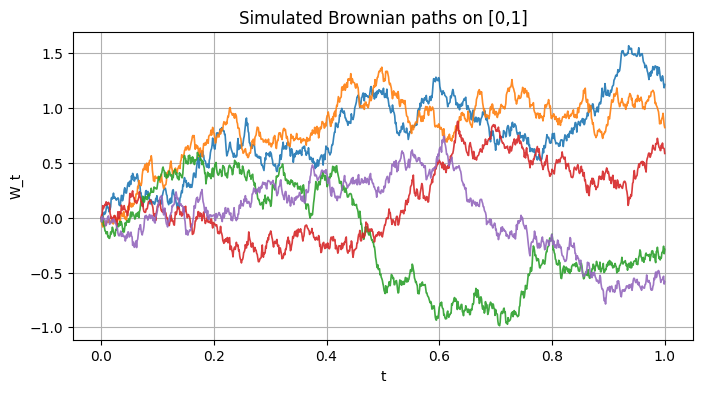

In [11]:
T = 1.0
n_steps = 1000
n_paths = 5

t, W = simulate_brownian_paths(T=T, n_steps=n_steps, n_paths=n_paths, rng=rng)

fig, ax = plt.subplots()
for i in range(n_paths):
    ax.plot(t, W[i], lw=1.2, alpha=0.9)
ax.set_title("Simulated Brownian paths on [0,1]")
ax.set_xlabel("t")
ax.set_ylabel("W_t")
plt.show()

The paths are continuous but highly irregular, with oscillations at every scale.

# 3. Gaussian marginals $W_t \sim \mathcal{N}(0,t)$

We now check empirically that, for a fixed time $t^*$, the distribution of $W_{t^*}$ is close to $\mathcal{N}(0, t^*)$.

## 3.1 Empirical mean and variance
We expect the empirical mean to be close to $0$ and the empirical variance close to $t^*$.


In [12]:
T = 1.0
n_steps = 1000
n_paths = 20_000

t, W = simulate_brownian_paths(T=T, n_steps=n_steps, n_paths=n_paths, rng=rng)

# choose t* as the final time T
t_star = T
idx_star = -1
samples = W[:, idx_star]

emp_mean = samples.mean()
emp_var = samples.var(ddof=1)

print(f"t* = {t_star}")
print(f"Empirical mean ≈ {emp_mean:.4f}   (theoretical: 0)")
print(f"Empirical var  ≈ {emp_var:.4f}   (theoretical: {t_star})")


t* = 1.0
Empirical mean ≈ 0.0023   (theoretical: 0)
Empirical var  ≈ 0.9903   (theoretical: 1.0)


The 20,000 simulated values of $W_{t^*}$ produce an empirical mean very close to 0 and a variance close to 1, exactly as predicted by the theoretical law $\mathcal{N}(0,1)$. This confirms that the simulated paths behave as a proper Brownian motion: their marginal distribution at time $t^*$ is Gaussian, centered, and with dispersion $\sqrt{t^*}$.


## 3.2 Histogram vs normal density

The empirical histogram should closely follow the normal density curve.

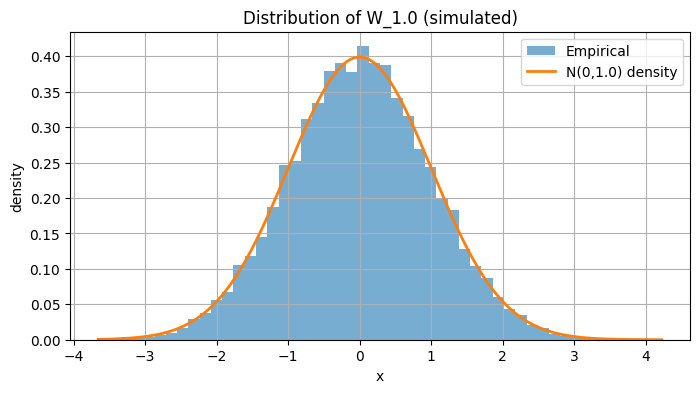

In [13]:
fig, ax = plt.subplots()

# histogram
ax.hist(samples, bins=50, density=True, alpha=0.6, label="Empirical")

# theoretical normal density
x_vals = np.linspace(samples.min(), samples.max(), 400)
pdf = stats.norm.pdf(x_vals, loc=0.0, scale=np.sqrt(t_star))
ax.plot(x_vals, pdf, lw=2.0, label=f"N(0,{t_star}) density")

ax.set_title(f"Distribution of W_{t_star} (simulated)")
ax.set_xlabel("x")
ax.set_ylabel("density")
ax.legend()
plt.show()


## 3.3 QQ-plot and Kolmogorov–Smirnov test

A QQ-plot compares empirical quantiles to theoretical quantiles of $\mathcal{N}(0, t^*)$.


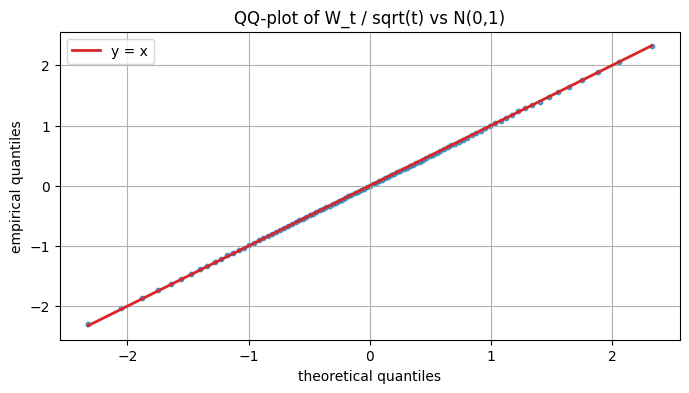

In [14]:
# Standardise samples to compare with N(0,1)
std_samples = samples / np.sqrt(t_star)

# theoretical and empirical quantiles
probs = np.linspace(0.01, 0.99, 99)
q_theo = stats.norm.ppf(probs, loc=0.0, scale=1.0)
q_emp = np.quantile(std_samples, probs)

fig, ax = plt.subplots()
ax.scatter(q_theo, q_emp, s=10, alpha=0.7)
ax.plot(q_theo, q_theo, color="tab:red", lw=2, label="y = x")
ax.set_title("QQ-plot of W_t / sqrt(t) vs N(0,1)")
ax.set_xlabel("theoretical quantiles")
ax.set_ylabel("empirical quantiles")
ax.legend()
plt.show()


The points lie almost exactly on the line $y = x$, showing that $W_t/\sqrt{t}$ matches a standard normal distribution very closely. The Gaussian assumption holds across the whole range of quantiles.

We can also run a Kolmogorov–Smirnov test against $\mathcal{N}(0,t^*)$. A large p-value (e.g. > 0.05) would be consistent with the Gaussian model.

In [15]:
ks_stat, p_value = stats.kstest(samples, "norm", args=(0.0, np.sqrt(t_star)))
print(f"KS statistic ≈ {ks_stat:.4f},  p-value ≈ {p_value:.4f}")

KS statistic ≈ 0.0044,  p-value ≈ 0.8400


# 4. Independent and stationary increments

We now check numerically that increments over disjoint intervals are:

- independent (uncorrelated in our simulations),
- stationary (distribution depends only on the length of the interval).

We consider a grid $0 = t_0 < t_1 < \cdots < t_m = T$ and define increments

$$\Delta W_k = W_{t_k} - W_{t_{k-1}}.$$


## 4.1 Sample correlations between increments

Off-diagonal entries should be close to zero, illustrating empirical independence of increments over disjoint intervals.

In [16]:
T = 1.0
n_steps = 1000
n_paths = 10_000

t, W = simulate_brownian_paths(T=T, n_steps=n_steps, n_paths=n_paths, rng=rng)

# choose a coarse grid of times
times_idx = [0, 250, 500, 750, 1000]   # corresponds to t = 0, 0.25, 0.5, 0.75, 1.0
times = t[times_idx]

# compute increments along this coarse grid
increments = []
for k in range(1, len(times_idx)):
    inc = W[:, times_idx[k]] - W[:, times_idx[k-1]]
    increments.append(inc)

increments = np.stack(increments, axis=1)  # shape (n_paths, nb_increments)

# correlation matrix of increments
corr_matrix = np.corrcoef(increments, rowvar=False)
corr_matrix_df = pd.DataFrame(
    corr_matrix,
    index=[f"ΔW_{k}" for k in range(1, increments.shape[1]+1)],
    columns=[f"ΔW_{k}" for k in range(1, increments.shape[1]+1)]
)
corr_matrix_df


,ΔW_1,ΔW_2,ΔW_3,ΔW_4
ΔW_1,1.000000,-0.008367,-0.010494,0.005148
ΔW_2,-0.008367,1.000000,0.004894,0.005830
ΔW_3,-0.010494,0.004894,1.000000,-0.009237
ΔW_4,0.005148,0.005830,-0.009237,1.000000


## 4.2 Stationarity of increments
We compare the empirical distribution of increments over intervals of the same length.

The two histograms should overlap closely and both match the normal density with variance equal to the interval length

Interval length: 0.25
Increment 1: mean ≈ 0.0013, var ≈ 0.2463
Increment 2: mean ≈ -0.0038, var ≈ 0.2510


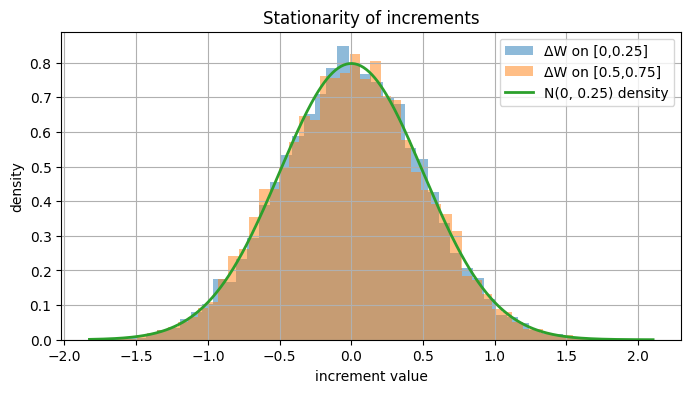

In [17]:
# increments over two different intervals of same length 0.25
inc1 = W[:, times_idx[1]] - W[:, times_idx[0]]   # [0, 0.25]
inc2 = W[:, times_idx[3]] - W[:, times_idx[2]]   # [0.5, 0.75]

emp_mean1, emp_var1 = inc1.mean(), inc1.var(ddof=1)
emp_mean2, emp_var2 = inc2.mean(), inc2.var(ddof=1)

print("Interval length:", times[1] - times[0])
print(f"Increment 1: mean ≈ {emp_mean1:.4f}, var ≈ {emp_var1:.4f}")
print(f"Increment 2: mean ≈ {emp_mean2:.4f}, var ≈ {emp_var2:.4f}")

fig, ax = plt.subplots()
ax.hist(inc1, bins=50, density=True, alpha=0.5, label="ΔW on [0,0.25]")
ax.hist(inc2, bins=50, density=True, alpha=0.5, label="ΔW on [0.5,0.75]")

x_vals = np.linspace(
    min(inc1.min(), inc2.min()),
    max(inc1.max(), inc2.max()),
    400
)
pdf = stats.norm.pdf(x_vals, loc=0.0, scale=np.sqrt(times[1] - times[0]))
ax.plot(x_vals, pdf, lw=2.0, label="N(0, 0.25) density")

ax.set_title("Stationarity of increments")
ax.set_xlabel("increment value")
ax.set_ylabel("density")
ax.legend()
plt.show()


# 5. Quadratic variation of Brownian motion

One of the defining features of Brownian motion is its quadratic variation:

$$[W]_T = \lim_{|\Pi| \to 0} \sum_k (W_{t_{k+1}} - W_{t_k})^2 = T,$$

where $\Pi$ runs over partitions of $[0,T]$ with mesh $|\Pi| \to 0$.

We approximate this numerically for a single path and a sequence of uniform grids.

As the time step $dt$ decreases, the approximate quadratic variation $Q_T(dt)$ should stabilise close to $T$.


In [18]:
T = 1.0
n_steps_base = 1000

# simulate a single Brownian path at high resolution
t_fine, W_fine = simulate_brownian_paths(T=T, n_steps=n_steps_base, n_paths=1, rng=rng)
W_fine = W_fine[0]

def quadratic_variation(t_grid, path):
    diffs = np.diff(path)
    return np.sum(diffs**2)

# consider coarser partitions by sub-sampling the fine grid
m_values = [10, 20, 40, 80, 160, 320, 640, 1000]
dt_values = []
qv_values = []

for m in m_values:
    # use m steps over [0,T]
    idx = np.linspace(0, n_steps_base, m+1, dtype=int)
    t_sub = t_fine[idx]
    W_sub = W_fine[idx]
    qv = quadratic_variation(t_sub, W_sub)
    dt = T / m
    dt_values.append(dt)
    qv_values.append(qv)

df_qv = pd.DataFrame({"dt": dt_values, "Q_T(dt)": qv_values})
df_qv


,dt,Q_T(dt)
0,0.100000,1.659166
1,0.050000,1.552533
2,0.025000,1.562420
3,0.012500,1.348042
4,0.006250,1.310088
5,0.003125,1.204256
6,0.001563,1.129413
7,0.001000,1.077109


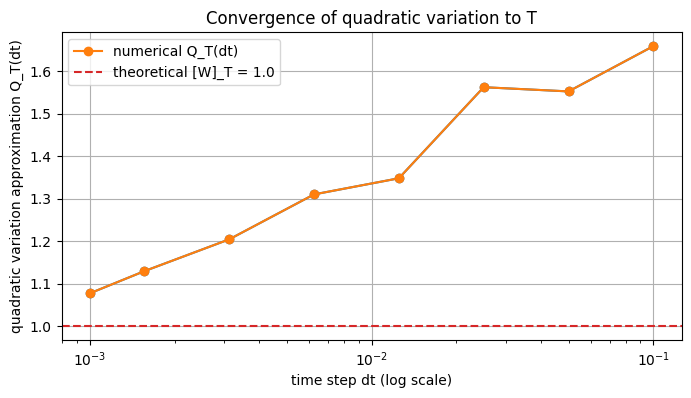

In [20]:
fig, ax = plt.subplots()

ax.plot(dt_values, qv_values, marker="o")
ax.plot(dt_values, qv_values, marker="o", label="numerical Q_T(dt)")
ax.axhline(T, color="tab:red", ls="--", label=f"theoretical [W]_T = {T}")
ax.set_xscale("log")
ax.set_xlabel("time step dt (log scale)")
ax.set_ylabel("quadratic variation approximation Q_T(dt)")
ax.set_title("Convergence of quadratic variation to T")
ax.legend()
plt.show()


The numerical quadratic variation stays above 1 for coarse grids and gets closer to the theoretical value as $dt$ decreases, showing the expected convergence toward $[W]_T = 1$.


# 6. Density estimation at fixed timeme

To finish, we visualise the empirical density of $W_t$ at some intermediate time $t^* \in (0,T)$ and compare it to $\mathcal{N}(0,t^*)$.$W_t$ at some intermediate time $t^* \in (0,T)$ and compare it to $\mathcal{N}(0,t^*)$.


t* = 0.5
Empirical mean ≈ -0.0044   (theoretical: 0)
Empirical var  ≈ 0.4932   (theoretical: 0.5)


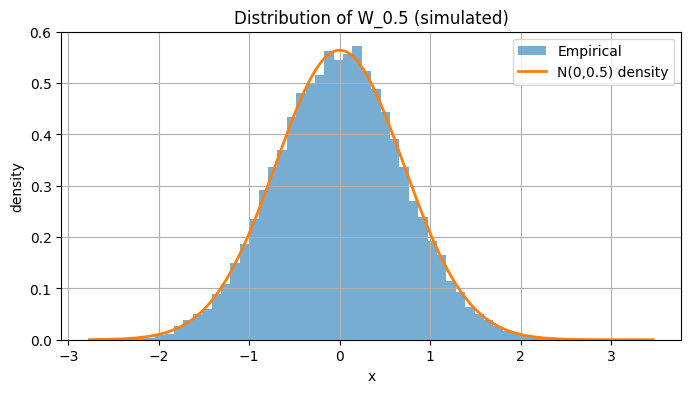

In [21]:
T = 1.0
n_steps = 1000
n_paths = 30_000

t, W = simulate_brownian_paths(T=T, n_steps=n_steps, n_paths=n_paths, rng=rng)

t_star = 0.5
idx_star = int(t_star * n_steps / T)
samples_mid = W[:, idx_star]

emp_mean_mid = samples_mid.mean()
emp_var_mid = samples_mid.var(ddof=1)

print(f"t* = {t_star}")
print(f"Empirical mean ≈ {emp_mean_mid:.4f}   (theoretical: 0)")
print(f"Empirical var  ≈ {emp_var_mid:.4f}   (theoretical: {t_star})")

fig, ax = plt.subplots()
ax.hist(samples_mid, bins=60, density=True, alpha=0.6, label="Empirical")

x_vals = np.linspace(samples_mid.min(), samples_mid.max(), 400)
pdf_mid = stats.norm.pdf(x_vals, loc=0.0, scale=np.sqrt(t_star))
ax.plot(x_vals, pdf_mid, lw=2.0, label=f"N(0,{t_star}) density")

ax.set_title(f"Distribution of W_{t_star} (simulated)")
ax.set_xlabel("x")
ax.set_ylabel("density")
ax.legend()
plt.show()


The empirical density again matches the theoretical Gaussian density with variance $t^*$.
